# Bayesian Linear Regression

In this notebook, we explore linear regression under the Bayesian framework. While traditional or frequentist linear regression treats the model parameters(such as the slope and intercept) as **deterministic**, Bayesian linear regression assumes that these parameters come from a hidden or **latent probability distribution**. The Bayesian framework has the clear benefit of incorporating **prior** domain knowledge an individual may have on a given dataset or application. A Bayesian treatment of regression can also help avoid overfitted or overly-complex models similar to regularized frequentist models, and an online update scheme can be easily derived. Let's start with a quick rundown of traditional linear regression.

## Notation

We will denote constants as lower case letters $a$, vectors as lower case letters with a vector symbol $\vec{a}$, and matrices as upper case bolded letters $\mathbf{A}$. 

## Frequentist Treatment

Suppose our data consists of i.i.d. target/response variables $t_i$ and corresponding predictor/explanatory variables $\vec{x_i} = (x_{i,0}, x_{i,1}, \ldots, x_{i,N-1})$. Rather than using the original data, it is common to instead use extracted/preprocessed features(see [monomial basis](https://en.wikipedia.org/wiki/Basis_function) and [RBF](https://en.wikipedia.org/wiki/Radial_basis_function) for examples), which we will denote $\vec{\phi_i} = \left(\phi_0(\vec{x_i}), \phi_1(\vec{x_i}), \ldots, \phi_{M-1}(\vec{x_i})\right)$. We then assume that $t_i$ has a linear relationship with $\vec{\phi_i}$. Adding random noise $\epsilon_i$, we have

\begin{align}
    t_i = \vec{w}^T\vec{\phi_i} + \epsilon_i
\end{align}

where $\vec{w} = (w_0, w_1, \ldots, w_{M-1})$ are our model parameters/coefficients. 

In the case of simple linear regression, 

\begin{align}
    \vec{x_i} &= x_i\\
    \vec\phi_i &= \left(\phi_0(x_i), \phi_1(x_i)\right) = (1, x_i) \\
    \vec{w} &= (w_0, w_1) \\
    \implies t_i &= \vec{w}^T\vec{\phi_i} + \epsilon_i = w_0 + w_1x_i + \epsilon_i
\end{align}

It is also common to assume that the random noise $\epsilon_i$ comes from a Gaussian distribution with zero mean and inverse variance(precision) $\beta$,

\begin{align}
    \epsilon_i \sim \mathcal{N}\left(0, \beta^{-1}\right)
\end{align}

We will treat $\beta$ as a known constant, but there are methods of incorporating it as an unknown.

In [1]:
# simple linear regression with no basis function for simplicity and sake of visualization
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

dim = 1
# generate toy data
numpoints = 100
x = np.linspace(-3, 3, numpoints)
x = x[np.newaxis].T

slope = 3
eps_mu = 0
beta = 0.25
eps = np.random.normal(eps_mu, 1/beta, size = (numpoints, dim))
t = slope * x + eps

# phi is a column of ones next to the column of x's
phi = np.hstack((np.ones((numpoints, 1)), x))

Because adding a constant to a Gaussian distribution shifts the mean by that constant, we have 

\begin{align}
    t_i \sim \mathcal{N}\left(\vec{w}^T\vec{\phi_i}, \beta^{-1}\right) \quad \text{or} \quad p\left(t_i \Big| \vec{w}^T\vec{\phi_i}, \beta^{-1}\right) = \mathcal{N}\left(\vec{w}^T\vec{\phi_i}, \beta^{-1}\right)
\end{align}

We can then write the **likelihood function** and log-likelihood function as a product of the individual likelihoods/log-likelihoods due to independence 

\begin{align}
    L(\vec{w}) &= \prod_{n = 1}^{N} p\left(t_i \Big| \vec{w}^T\vec{\phi_i}, \beta^{-1}\right) = \prod_{n = 1}^{N} \frac{1}{\sqrt{2\pi \beta^{-1}}} \exp{\left(-\frac{1}{2}\frac{\left(t_n - \vec{w}^T\vec{\phi_i}\right)^2}{\beta^{-1}}\right)} \\
    &= \left(2\pi \beta^{-1}\right)^{-N/2} \exp{\left(-\frac{\beta}{2} \displaystyle\sum_{n = 1}^{N} \left(t_n - \vec{w}^T\vec{\phi_i}\right)^2 \right)} \\
    \log L(\vec{w}) &= -\frac{N}{2}\log(2\pi) + \frac{N}{2}\log(\beta) - \frac{\beta}{2}\displaystyle\sum_{n = 1}^{N}\left(t_n - \vec{w}^T\vec{\phi_i}\right)^2
\end{align}

**Maximizing** the log-likelihood is the same as maximizing the likelihood, so taking the gradient with respect to $\vec{w}$ and setting to zero yields the famous **normal equations**, 

\begin{align}
    \nabla_\vec{w} \log L(\vec{w}) &= - \beta\sum_{n = 1}^{N} \left(t_n - \vec{w}^T \vec{\phi_n}\right) \vec{\phi_n}^T = 0 \\
    \implies \vec{w_{ML}} &= \left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^{-1} \vec{t}
\end{align}

where $\mathbf{\Phi} = \left(\vec{\phi_0}, \vec{\phi_1}, \ldots, \vec{\phi_N}\right)^T$ is often referred to as the **design matrix**.

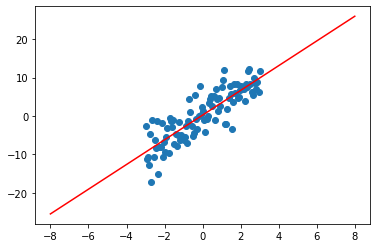

In [2]:
# pinv is generally avoided since singular matrices can cause problems
#w = np.linalg.pinv(phi.T @ phi) @ phi.T @ t

# use lstsq instead, it solves for x in Ax = b
w = np.linalg.lstsq(phi.T @ phi, phi.T @ t, rcond=None)[0]

# plot data and fitted reg. line
line_x_ls = np.linspace(np.min(x)-5, np.max(x) + 5, 100)
line_y_ls = w[0] + w[1]*line_x_ls
plt.scatter(x, t)
plt.plot(line_x_ls, line_y_ls, 'r')
plt.show()

## Bayesian Treatment

Bayesian linear regression follows the same setup as the frequentist framework, except that we now assume that $\vec{w}$ belongs to a **prior** distribution. It turns out that because the likelihood function $L(\vec{w})$ is the exponential of a quadratic function of $\vec{w}$, this prior is a multivariate Gaussian distribution [Bishop 152]

\begin{align}
    \vec{w} \sim \mathcal{N}\left(\vec{m_0}, \mathbf{S}_0\right) \quad \text{or} \quad p(\vec{w}) = \mathcal{N}\left(\vec{w} \Big| \vec{m_0}, \mathbf{S}_0\right)
\end{align}

where $\vec{m_0}$ and $\mathbf{S}_0$ are the initial "guesses" of the mean and covariance of $\vec{w}$. The posterior distribution of $\vec{w}$ can then be found using Baye's Rule, 

\begin{align}
    p(\vec{w} | \vec{t} ) \propto p(\vec{t} | \vec{w}) p(\vec{w})
\end{align}

Note that $p(\vec{t} | \vec{w})$ is the likelihood given in the frequentist formulation (since we view $\vec{x}$ and $\beta$ as constant). The posterior distribution of a Gaussian will in turn be Gaussian, and given the prior and likelihood distributions [Bishop 90-93]

\begin{align}
    p(\vec{w}) &= \mathcal{N}\left(\vec{w} \Big| \vec{m_0}, \mathbf{S_0}\right) = \mathcal{N}\left(\vec{w} \Big| \vec{\mu}, \mathbf{\Lambda}^{-1}\right) \\
    p(\vec{t} | \vec{w}) &= \mathcal{N}\left(\vec{t} \Big| \mathbf{\Phi}\vec{w}, \beta^{-1}I \right) = \mathcal{N}\left(\vec{t} \Big| \mathbf{A}\vec{w} + \vec{b}, \mathbf{L}^{-1}\right) 
\end{align}

the posterior distribution will have the following form (Bishop 93)

\begin{align}
    p(\vec{w} | \vec{t}) = \mathcal{N}\left(\vec{w} \Big| \left(\mathbf{\Lambda} + \mathbf{A}^T\mathbf{L}\mathbf{A}\right)^{-1}\left(\mathbf{A}^T\mathbf{L}(\vec{t} - \vec{b}) + \mathbf{\Lambda} \vec{\mu}\right), \left(\mathbf{\Lambda} + \mathbf{A}^T\mathbf{L}\mathbf{A}\right)^{-1} \right)
\end{align}

This works out to be 

\begin{align}
    p(\vec{w} | \vec{t}) &= \mathcal{N}\left( \vec{w} \Big| \vec{m}_N, \mathbf{S}_N \right) \\
    \vec{m}_N &= \mathbf{S}_N\left(S_0^{-1} \vec{m_0} + \beta \mathbf{\Phi}^T \vec{t} \right) \\
    \mathbf{S}_N^{-1} &= \mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}
\end{align}

Rather than maximizing the likelihood, we instead maximize the posterior, or **maximum a posteriori(MAP)** (which is actually equivalent to MLE if the prior is constant or uniform). In the case of a Gaussian posterior distribution, the mode coincides with the mean, thus 

\begin{align}
    \vec{w}_{MAP} = \vec{m}_N
\end{align}

For the skeptical, we can also compute this directly. Recall that $w \in \mathbb{R}^M$, thus 

\begin{align}
    p(\vec{w} | \vec{t}) &= \frac{1}{(2\pi)^{M/2}} \frac{1}{|S_N|^{1/2}} \exp \left( -\frac{1}{2}(\vec{w} - \vec{m}_N)^T S_N^{-1} (\vec{w} - \vec{m}_N) \right) \\
    \implies \log p(\vec{w} | \vec{t}) &= -\frac{M}{2} \log(2\pi) - \frac{1}{2} \log(|S_N|) - \frac{1}{2}(\vec{w} - \vec{m}_N)^T S_N^{-1} (\vec{w} - \vec{m}_N) \\
    \implies \frac{\partial \log p(\vec{w} | \vec{t})}{\partial \vec{w}} &= -S_N^{-1} (\vec{w} - \vec{m}_N) = 0 \\
    \implies \vec{w}_{MAP} &= \vec{m}_N
\end{align}

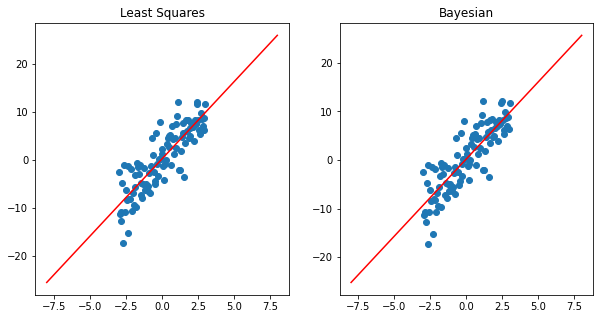

In [3]:
# choose an uninformative prior for simplicity
m_0 = np.array([[0], [0]])
S_0 = np.eye(2)
beta = 0.25

S_0inv = np.linalg.lstsq(S_0, np.eye(2), rcond = None)[0]
S_n = np.linalg.lstsq(S_0inv + beta * phi.T @ phi, np.eye(2), rcond = None)[0]
m_n = S_n @ (S_0inv @ m_0 + beta * phi.T @ t)

line_x_b = np.linspace(np.min(x)-5, np.max(x) + 5, 100)
line_y_b = m_n[0] + m_n[1]*line_x_b

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].title.set_text("Least Squares")
ax[0].scatter(x, t)
ax[0].plot(line_x_ls, line_y_ls, 'r')
ax[1].title.set_text("Bayesian")
ax[1].scatter(x, t)
ax[1].plot(line_x_b, line_y_b, 'r')
plt.show()

The fitted Bayesian model is almost identical to the frequentist model in this simple regression case. This is because we considered a zero-mean **isotropic prior**(where $m_0 = 0$ and $S_0 = \alpha^{-1} I$ for some constant $\alpha$), thus maximizing the log-posterior yields an **identical solution** to that of MLE(with an added regularization term). In other words, if our prior for $\vec{w}$ is uninformative, Bayesian regression reduces to frequentist regression. We will explore this idea further after a quick detour to an online version of Bayesian regression.

## Regularization

As previously mentioned, a zero-mean isotropic prior leads to a maximum a posteriori solution identical to the MLE solution for regularized frequentist regression(specifically ridge regression). We can see this by direct computation of the log posterior. Rather than recomputing the posterior, we can simply add the log likelihood(same likelihood as the frequentist version) and log prior.  Recall that the prior and log prior are 

\begin{align}
    p(\vec{w}) &= \mathcal{N}\left(\vec{0}, \alpha^{-1}I\right) = \frac{1}{(2\pi)^{M/2}} \frac{1}{|\alpha^{-1}I|} \exp\left(-\frac{1}{2} \vec{w}^T (\alpha^{-1}I)^{-1} \vec{w}\right) \\
    \log p(\vec{w}) &= -\frac{M}{2} \log(2\pi) - M \log \alpha - \frac{\alpha}{2} \vec{w}^T \vec{w}
\end{align}

Thus the log posterior is 

\begin{align}
    \log p(\vec{w} | \vec{t}) &= \log L(\vec{w}) + \log p(\vec{w}) \\
    &= -\frac{N}{2}\log(2\pi) + \frac{N}{2}\log(\beta) - \frac{\beta}{2}\displaystyle\sum_{n = 1}^{N}\left(t_n - \vec{w}^T\vec{\phi_i}\right)^2 -\frac{M}{2} \log(2\pi) - M \log \alpha - \frac{\alpha}{2} \vec{w}^T \vec{w} \\
    \implies \frac{2}{\beta} \log p(\vec{w} | \vec{t}) &= - \displaystyle\sum_{n = 1}^{N}\left(t_n - \vec{w}^T\vec{\phi_i}\right)^2 - \frac{\alpha}{\beta} \vec{w}^T \vec{w} + constant
\end{align}

The log posterior is identical to the loss function for ridge regression with $\lambda = \frac{\alpha}{\beta}$, and minimizing it will yield the same solution to ridge regression. Because a larger $\alpha$ reflects a stronger belief in the prior, a large $\alpha$ will result in regularization. However, this is double-edged: a strong belief in an incorrect prior can lead to misleading results or worse fits. We can demonstrate this regularizing effect in the following example of a $4$-dimensional polynomial.

frequentist: [[ 5.56943855  1.14653262 -0.76132086 -0.12806114  0.57386762]]
Bayesian:    [[ 1.73468395  0.43333639  0.77427287 -0.01914878  0.44023857]]


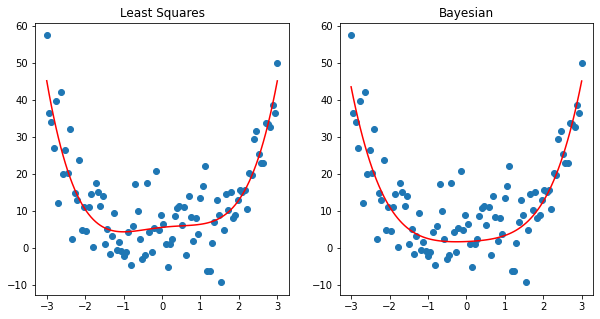

In [4]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# generate toy data
dim = 1
numpoints = 100
x = np.linspace(-3, 3, numpoints)
x = x[np.newaxis].T

eps_mu = 4
beta = 0.125
eps = np.random.normal(eps_mu, 1/beta, size = (dim, numpoints)).T
t = 0.5 * x**4 + eps

# phi is 5 columns of x^i for i in {0, 1,... 4}
phi = np.hstack((np.ones((numpoints, 1)), x, x**2, x**3, x**4))

# use lstsq instead, it solves for x in Ax = b
w = np.linalg.lstsq(phi.T @ phi, phi.T @ t, rcond=None)[0]
print("frequentist:", w.T)
# draw fitted polynomial
line_x_ls = np.linspace(np.min(x), np.max(x), 100)
line_y_ls = w[0] + w[1]*line_x_ls + w[2]*line_x_ls**2 + w[3]*line_x_ls**3 + w[4]*line_x_ls**4 

# zero-mean isotropic prior with alpha = 10
m_0 = np.array([[0], [0], [0], [0], [0]])
S_0 = 0.1 * np.eye(5)
beta = 0.125

# calculate bayesian params
S_0inv = np.linalg.lstsq(S_0, np.eye(5), rcond = None)[0]
S_n = np.linalg.lstsq(S_0inv + beta * phi.T @ phi, np.eye(5), rcond = None)[0]
m_n = S_n @ (S_0inv @ m_0 + beta * phi.T @ t)
# draw bayesian fitted polynomial
line_x_b = np.linspace(np.min(x), np.max(x), 100)
line_y_b = m_n[0] + m_n[1]*line_x_b + m_n[2]*line_x_b**2 + m_n[3]*line_x_b**3 + m_n[4]*line_x_b**4 
print("Bayesian:   ", m_n.T)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].title.set_text("Least Squares")
ax[0].scatter(x, t)
ax[0].plot(line_x_ls, line_y_ls, 'r')
ax[1].title.set_text("Bayesian")
ax[1].scatter(x, t)
ax[1].plot(line_x_b, line_y_b, 'r')
plt.show()

With a relatively strong prior, we can see that the Bayesian model penalizes large coefficients and leads to a relatively simpler model than the frequentist one. We would see a similar effect if we applied ridge regression with $\lambda = 40$. 

However, this is all with a prior mean of $0$. If we consider a **non-zero mean**, we could attempt to nudge the Bayesian coefficients in a certain direction. Although this effect would most likely be lost with the addition of more data, it is more pronounced during early stages of training when there is fewer data available. Consider the case with the first $n = 20$ observations rather than the full $n = 100$. We may have reason to believe that the data follows a parabolic shape(a $2$ degree polynomial looks similar to a $4$ degree polynomial after all). Setting the prior for the second degree coefficient to be nonzero, we end up something different.

frequentist:         [[ 4.9188231   0.36609691 -3.0021992  -0.09691039  0.90402365]]
Bayesian:            [[ 0.22873539  0.0360912  -0.1542613  -0.04875233  0.61665565]]
nonzero Bayesian:    [[-0.94911325  0.0360912   7.12360949 -0.04875233 -0.30824501]]


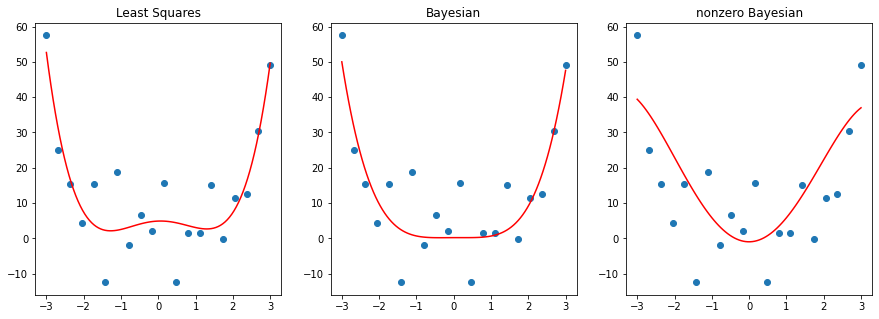

In [5]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# generate toy data
numpoints = 20
x = np.linspace(-3, 3, numpoints)
x = x[np.newaxis].T

eps_mu = 4
beta = 0.125
eps = np.random.normal(eps_mu, 1/beta, size = (dim, numpoints)).T
t = 0.5 * x**4 + eps

# phi is 5 columns of x^i for i in {0, 1,... 4}
phi = np.hstack((np.ones((numpoints, 1)), x, x**2, x**3, x**4))

# use lstsq instead, it solves for x in Ax = b
w = np.linalg.lstsq(phi.T @ phi, phi.T @ t, rcond=None)[0]
print("frequentist:        ", w.T)
# draw fitted polynomial
line_x_ls = np.linspace(np.min(x), np.max(x), 100)
line_y_ls = w[0] + w[1]*line_x_ls + w[2]*line_x_ls**2 + w[3]*line_x_ls**3 + w[4]*line_x_ls**4 

# zero-mean isotropic prior with alpha = 10
m_0 = np.array([[0], [0], [0], [0], [0]])
S_0 = 0.1 * np.eye(5)
beta = 0.125

# calculate bayesian params
S_0inv = np.linalg.lstsq(S_0, np.eye(5), rcond = None)[0]
S_n = np.linalg.lstsq(S_0inv + beta * phi.T @ phi, np.eye(5), rcond = None)[0]
m_n = S_n @ (S_0inv @ m_0 + beta * phi.T @ t)
# draw bayesian fitted polynomial
line_x_b1 = np.linspace(np.min(x), np.max(x), 100)
line_y_b1 = m_n[0] + m_n[1]*line_x_b + m_n[2]*line_x_b**2 + m_n[3]*line_x_b**3 + m_n[4]*line_x_b**4 
print("Bayesian:           ", m_n.T)

# nonzero-mean isotropic prior with alpha = 10
m_0 = np.array([[0], [0], [10], [0], [0]])
S_0 = 0.1 * np.eye(5)
beta = 0.125

# calculate bayesian params
S_0inv = np.linalg.lstsq(S_0, np.eye(5), rcond = None)[0]
S_n = np.linalg.lstsq(S_0inv + beta * phi.T @ phi, np.eye(5), rcond = None)[0]
m_n = S_n @ (S_0inv @ m_0 + beta * phi.T @ t)
# draw bayesian fitted polynomial
line_x_b2 = np.linspace(np.min(x), np.max(x), 100)
line_y_b2 = m_n[0] + m_n[1]*line_x_b + m_n[2]*line_x_b**2 + m_n[3]*line_x_b**3 + m_n[4]*line_x_b**4 
print("nonzero Bayesian:   ", m_n.T)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].title.set_text("Least Squares")
ax[0].scatter(x, t)
ax[0].plot(line_x_ls, line_y_ls, 'r')
ax[1].title.set_text("Bayesian")
ax[1].scatter(x, t)
ax[1].plot(line_x_b1, line_y_b1, 'r')
ax[2].title.set_text("nonzero Bayesian")
ax[2].scatter(x, t)
ax[2].plot(line_x_b2, line_y_b2, 'r')
plt.show()

With less data, our prior has a larger influence on the resulting model. Specifically, the nonzero mean pushed the model to a simpler $2$ degree fit. 

While this seems beneficial, priors are a tricky business. As mentioned before, incorrect priors could mislead the fit of a model, and in the absence of a meaningful prior the Bayesian model reduces to a regularized frequentist one. While the use of hyperpriors and hierarchical extensions may improve results, these hyperdistributions may not necessarily provide an accurate prior. Although Bayesian models don't see significant improvements over frequentist ones in practice, their motivations and accompanying Bayesian methods of analysis should not be overlooked. 

## Sources

[1] Bishop, Christopher M. Pattern Recognition and Machine Learning. Springer, 2006. 
